In [2]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, CuDNNLSTM, LayerNormalization
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import numpy as np
import seaborn as sns; sns.set()
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

Using TensorFlow backend.


In [0]:

import numpy as np
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
from copy import deepcopy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.summarization import bm25
import nltk
import numpy as np
import random
import pickle
import scipy
import sklearn
import tqdm

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation,concatenate,Embedding,LSTM,Conv1D,MaxPooling1D,Flatten,Input,Bidirectional,CuDNNLSTM
from tensorflow.keras.layers import Subtract,Lambda,Add,BatchNormalization
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras.utils.vis_utils import model_to_dot	
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [0]:
import tensorflow.keras 
import tensorflow.keras.backend as K
def softmax_(x):
  return tensorflow.keras.activations.softmax(x, axis=1)# creates some issue with the generation at the end of target string

def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

In [0]:
charachters=sorted(["b","c","d","f","g","h","j","k","l","m","n","p","q","r","s","t","v","w","x","y","z","a","e","i","o","u"])
vocab_size=len(charachters)

## MODEL

In [7]:
# Hyperparamteres #
T=200
d_model=50#  ≥ input_d
dk=50
dv=50
h=3
dff=200
P_drop=0.1
N=2
mha_activation="linear"
# Hyper paramteres #
#vocab_size=25
input_d=15

sent_inp=Input(shape=(T,))
input_embedding=Embedding(vocab_size + 1,input_d,input_length=T,trainable=True)(sent_inp)
pos_inp = Input(shape=(T,))
position_embedding=Embedding(T + 1,d_model - input_d,input_length=T,trainable=True)(pos_inp)
final_inp = Concatenate(axis=-1)([position_embedding,input_embedding])
sublayer_out = final_inp
alphas_list=[]
for n in np.arange(N):
  ################### LAYER ##################
  sublayer_in=sublayer_out # joining with last Layer
  i_v=sublayer_in # Values
  i_k=sublayer_in # Keys
  
  ############# SELF Attention SUBLAYER #############
  Dense_K=[Dense(dk,activation=mha_activation) for i in np.arange(h)]
  Dense_Q=[Dense(dk,activation=mha_activation) for i in np.arange(h)]
  Dense_V=[Dense(dv,activation=mha_activation) for i in np.arange(h)]
  Dense_dmodel= Dense(d_model)
  all_times_out=[]
  for t in np.arange(T):# iterate with different queries.
    i_q = Lambda(lambda x : x[:,t,:])(sublayer_in) # Queries
    ######### MULTI HEAD ATTENTION #########
    all_heads=[]
    for i in np.arange(h): #
      k=Dense_K[i](i_k)# time distributed
      q=Dense_Q[i](i_q)# not time distributed
      v=Dense_V[i](i_v)# time distributed
      #### Scaled Dot Product Attention ####
      d=Dot(axes = -1)([k,q])
      d1=Lambda(lambda x: x/(np.sqrt(dk)))(d)
      alphas=Activation(softmax,name="head_"+str(i+1)+"time_"+str(t+1)+"layer"+str(n+1))(d1)
      alphas_list.append(alphas) # for purely visualization purposes
      contex_v = Dot(axes = 1)([alphas,v])
      #### Scaled Dot Product Attention ####
      all_heads.append(contex_v)
    concat = Concatenate(axis=1)(all_heads)
    final = Dense_dmodel(concat)
    final = RepeatVector(1)(final)#to create an extra one axis. (None, d_model) ---> (None,1,d_model) # so that later (None,T,d_model)
    all_times_out.append(final)
    ######### MULTI HEAD ATTENTION #########
  all_times_out=Concatenate(axis=1)(all_times_out) # T times (None,1,d_model) ----> (None,T,d_model)
  all_times_out=Dropout(P_drop)(all_times_out)
  sublayer_out = Add()([all_times_out,sublayer_in])# Residual connection
  sublayer_out = LayerNormalization()(sublayer_out)# default axis -1
  ############# SELF Attention SUBLAYER #############

  ############# Feed Forward SUBLAYER #############
  sublayer_in=sublayer_out
  dense1=Dense(dff,activation="relu")(sublayer_in)
  dense2=Dense(d_model,activation="linear")(dense1)
  dense2=Dropout(P_drop)(dense2)
  sublayer_out = Add()([dense2,sublayer_in])# Residual connection
  sublayer_out = LayerNormalization()(sublayer_out)# default axis -1
  ############# Feed Forward SUBLAYER #############
  
  ################### LAYER ##################

o=Dense(vocab_size,activation="softmax")(sublayer_out)

model=Model(inputs=[sent_inp,pos_inp],outputs=[o])
visualize_model=Model(inputs=[sent_inp,pos_inp],outputs=[o]+alphas_list)
#model.summary()# just too big





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.count_params()

111066

In [0]:
#plot_model(model, to_file='model.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
sample=model.predict([np.random.randint(low=0,high=vocab_size,size=(1,T)),np.reshape(np.arange(T),(1,T))])
sample.shape

(1, 300, 26)

In [10]:
sample=visualize_model.predict([np.random.randint(low=0,high=vocab_size,size=(1,T)),np.reshape(np.arange(T),(1,T))])
assert np.array(sample[1:]).shape[0]== h*T*N
print(h*T*N,"attentions")


1200 attentions


### Create Training Testing Data from RAW sentences

In [0]:
##create 10 digit random charachter sequences
data_size=10000
rawdata=[random.sample(charachters*50,T) for i in range(data_size)]
reversedraw=[reversed(i) for i in rawdata]
seqdata=np.array([np.array([charachters.index(j) for j in i]) for i in rawdata])
reversedseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in reversedraw])

In [12]:
seqdata,reversedseqdata

(array([[ 4,  5,  8, ...,  6,  9,  7],
        [14,  8, 14, ...,  4, 20,  5],
        [17,  4, 24, ...,  0,  1, 18],
        ...,
        [21, 17, 25, ...,  9, 17,  4],
        [23,  7, 21, ..., 11, 22,  3],
        [ 5,  4, 10, ...,  7,  6, 17]]), array([[ 7,  9,  6, ...,  8,  5,  4],
        [ 5, 20,  4, ..., 14,  8, 14],
        [18,  1,  0, ..., 24,  4, 17],
        ...,
        [ 4, 17,  9, ..., 25, 17, 21],
        [ 3, 22, 11, ..., 21,  7, 23],
        [17,  6,  7, ..., 10,  4,  5]]))

In [0]:
assert (seqdata == np.argmax(to_categorical(seqdata,num_classes=vocab_size),axis=-1)).all()

In [0]:
target=to_categorical(reversedseqdata)

In [15]:
target.shape

(10000, 200, 26)

In [16]:
seqdata.shape,  target.shape#,arange.shape,1

((10000, 200), (10000, 200, 26))

In [17]:
custom_adam=adam(lr=0.009, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(custom_adam,loss="categorical_crossentropy",metrics=["accuracy"])

In [0]:
arange=np.tile(np.arange(T),data_size).reshape(data_size,T)
history=model.fit([seqdata,arange],target,epochs=3,batch_size=100, verbose=1) 

In [0]:
##create 10 digit random charachter sequences
Tdata_size=100
Trawdata=[random.sample(charachters*50,T) for i in range(Tdata_size)]
Tseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in Trawdata])

In [0]:
def showresults(data):
  Tseqdata=np.array([np.array([charachters.index(j) for j in i]) for i in data])
  items=[]
  for ind,sample in enumerate(Tseqdata):
    arange=np.tile(np.arange(T),1).reshape(1,T) 
    ouput=model.predict([sample.reshape(1,T),arange])
    ouput=np.array(ouput)
    ouput=np.argmax(ouput,axis=-1).reshape(1,T)[0]
    ouput="".join([charachters[int(j)] for j in ouput])
    iput="".join([i for i in data[ind]])
    items.append([iput,ouput])
  return items

In [22]:
showresults(Trawdata[:50])## Testing Data

[['egpbsmtiwuzjchpofezodawympofzacasoxpahvvsimfolrguwtfoknksmhvuqorbzridyznjgcjhtxsinhpiidoxpsnqnmuwjodthfqcqdgqetbcwwvbmcewegjevdipzdnwcglsvxdsivvxmezomomsvpysmeaksnknkozqlinwmwbzomwoyrrixhbwfycbrrzlaof',
  'foalzrrbcyfwbhxirryowmozbwmwnilqzoknknskaemsypvsmomozemxvvisdxvslgcwndzpidvejgewecmbvwwcbteqgdqcqfhtdojwumnqnspxodiiphnisxthjcgjnzydirzbroquvhmsknkoftwugrlofmisvvhapxosacazfopmywadozefophcjzuwitmsbpge'],
 ['opladitkryiepjxgydmavkwkxbdwmzbvqpjrnrwrhqtnqbfhdgnulhlafmzsyojfruezwgwllebccklrnwixqmjfzmnbmbjbwehttvmypnmzyubsbatrdumjxwcdqxnfiziaraahlbbbxxmxifckyxdgbhkcfpufnikusofqwceyelthhohnjtdsbkcutscwmnceceqo',
  'oqececnmwcstuckbsdtjnhohhtleyecwqfosukinfupfckhbgdxykcfixmxxbbblhaaraizifnxqdcwxjmudrtabsbuyzmnpymvtthewbjbmbnmzfjmqxiwnrlkccbellwgwzeurfjoyszmfalhlungdhfbqntqhrwrnrjpqvbzmwdbxkwkvamdygxjpeiyrktidalpo'],
 ['yonvceiiwgywewoqrxaajgqtewojmnpwfszrqyqdhbrhwfvydtxpuimpdccpfxrbalmoiebbbtizawzfkjtuoyzkknzprkcyttrwbsrdioxfvgkrgdcmgtokztnleqpwkjofebbxrunkioteyngytlmftkplisdcwbirmsmmtus

In [0]:
#showresults(rawdata[:50]) #Training Data
#plt.plot(history.history["loss"])

In [26]:
Tseqdata[bs].shape

(200,)

In [30]:
Tseqdata[bs].reshape(1,T).shape,arange.shape

((1, 200), (1, 200))

In [0]:
bs =  random.sample(range(1, 100), 20)[0]


In [0]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [88]:
h

3

In [89]:
t1=np.array(list(chunks(o1,h)))
t2=np.sum(t1,axis=1)
t2.shape

(400, 200)

In [97]:
t2=np.sum(t1,axis=1)
t1.shape,t2.shape

((400, 3, 1, 200), (400, 1, 200))

In [98]:
t2.shape,o.shape

((400, 1, 200), (1200, 1, 200))

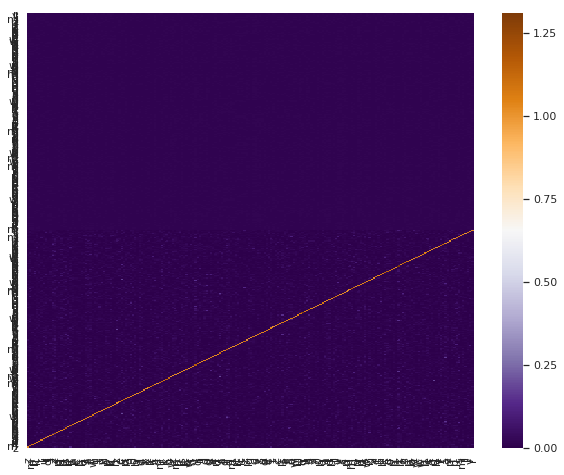

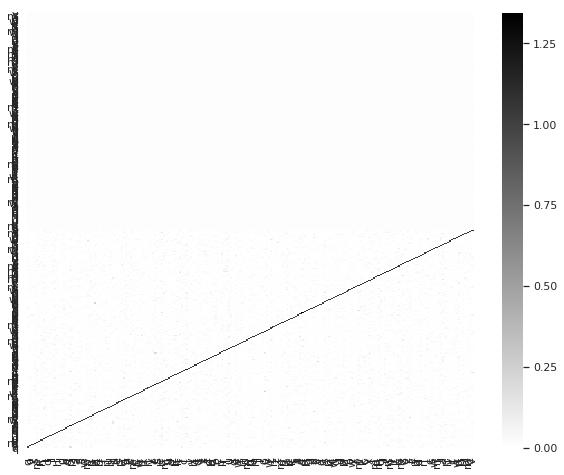

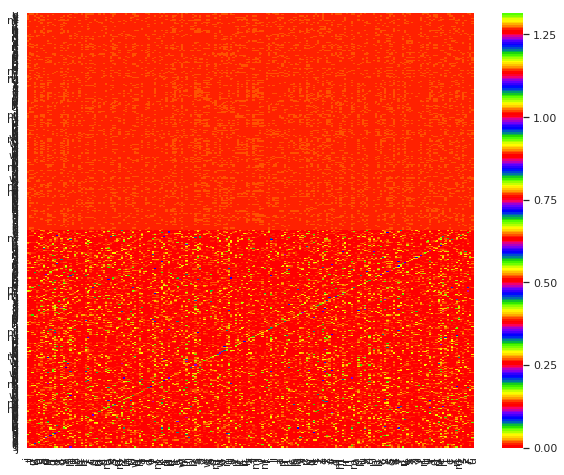

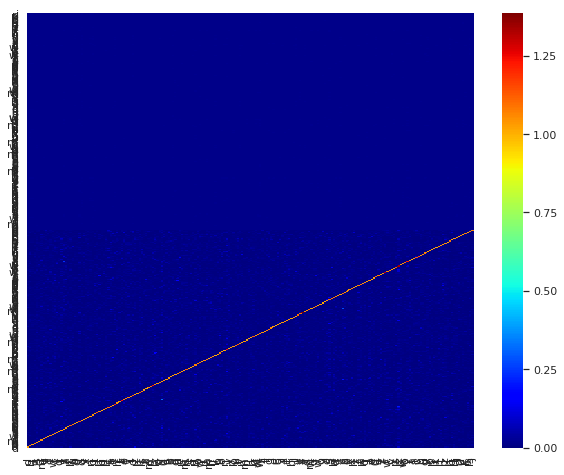

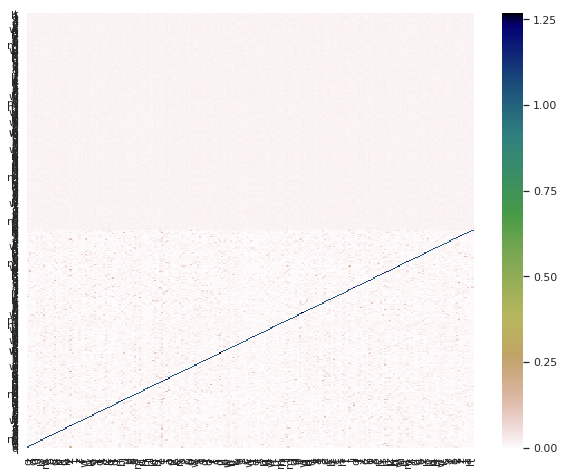

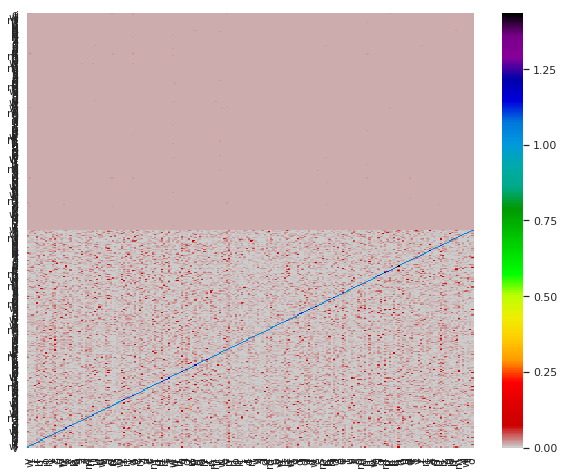

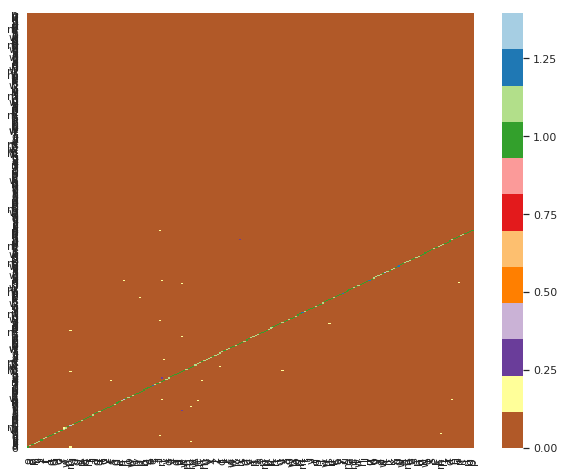

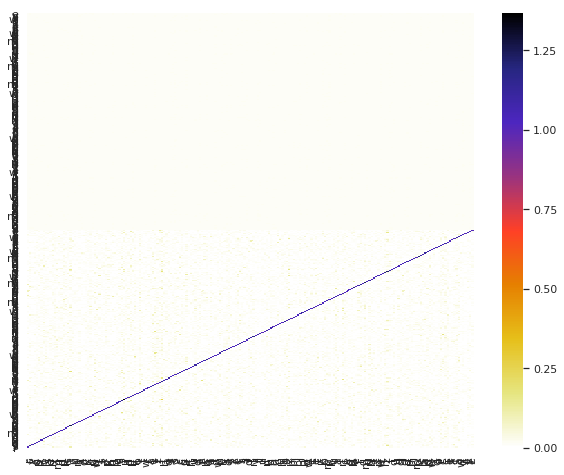

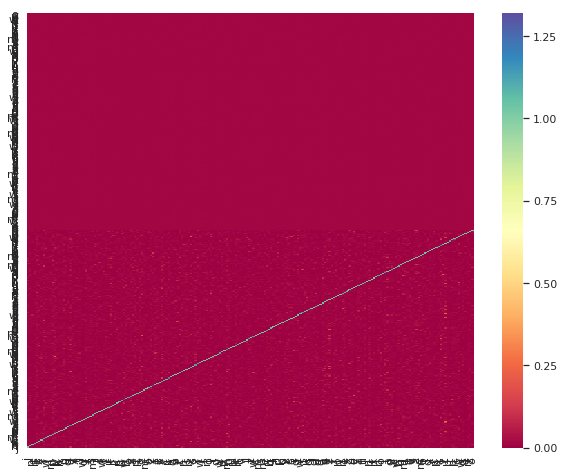

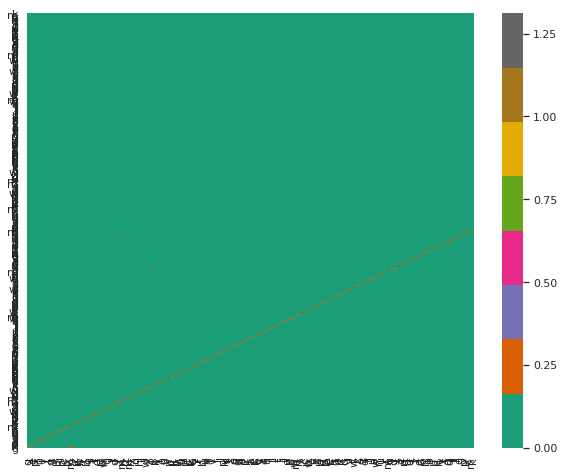

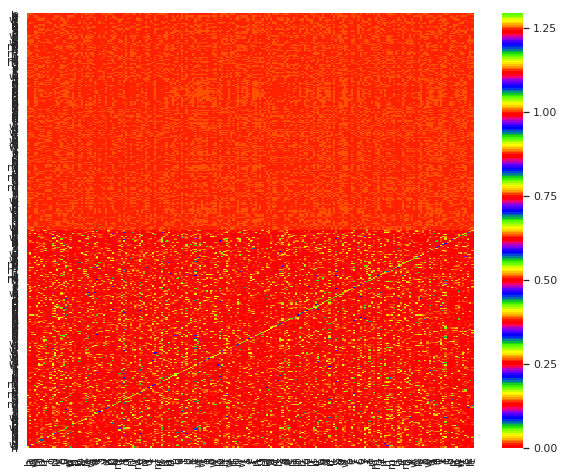

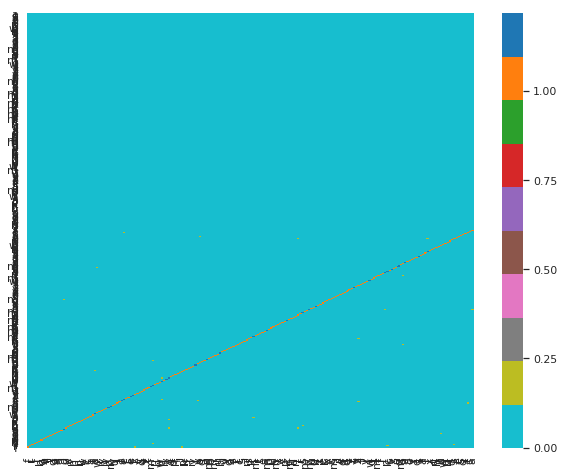

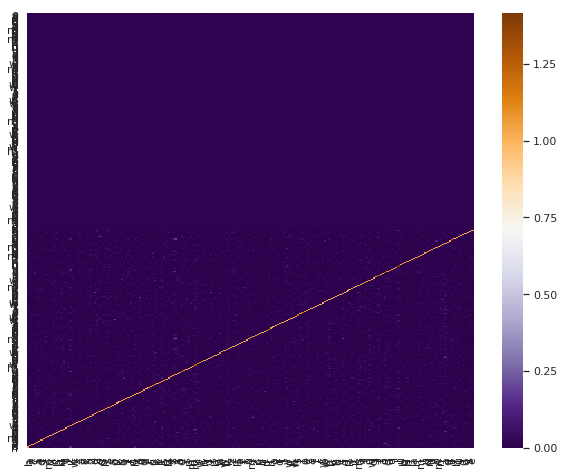

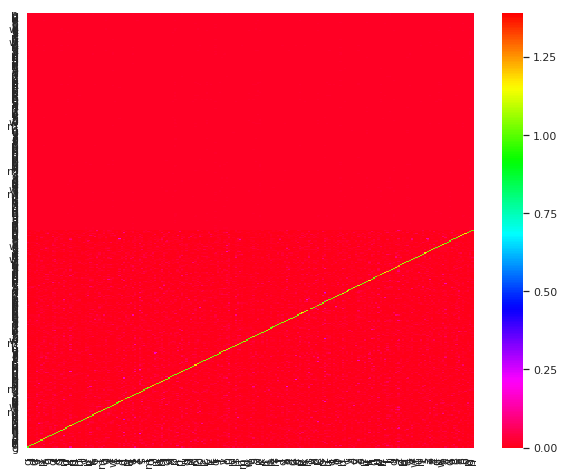

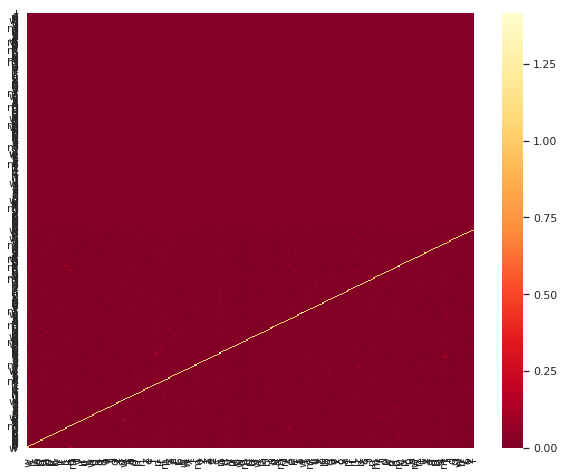

In [0]:
for bs in  random.sample(range(1, 100), 20):       
  arange=np.tile(np.arange(T),1).reshape(1,T)
  inp=Tseqdata[bs].reshape(1,T)
  o=visualize_model.predict([inp,arange])
  y=o[0]
  o=o[1:]
  o=np.array(o)
  o=o.reshape(N*T*h,T)
  t1=np.array(list(chunks(o,h)))
  t2=np.sum(t1,axis=1)
  #y=y.swapaxes(0,1)[0]
  y=np.argmax(y,axis=-1)
  y=y[0]
  xlabels= [charachters[j] for j in Tseqdata[bs]]
  ylabels=[charachters[j] for j in y]  
  fig, ax = plt.subplots(figsize=(10,8))
  sns.heatmap(t2,xticklabels=xlabels,yticklabels=ylabels*2,cmap=random.choice(["Accent","Accent_r","Blues","Blues_r","BrBG","BrBG_r","BuGn","BuGn_r","BuPu","BuPu_r","CMRmap","CMRmap_r","Dark2","Dark2_r","GnBu","GnBu_r","Greens","Greens_r","Greys","Greys_r","OrRd","OrRd_r","Oranges","Oranges_r","PRGn","PRGn_r","Paired","Paired_r","Pastel1","Pastel1_r","Pastel2","Pastel2_r","PiYG","PiYG_r","PuBu","PuBuGn","PuBuGn_r","PuBu_r","PuOr","PuOr_r","PuRd","PuRd_r","Purples","Purples_r","RdBu","RdBu_r","RdGy","RdGy_r","RdPu","RdPu_r","RdYlBu","RdYlBu_r","RdYlGn","RdYlGn_r","Reds","Reds_r","Set1","Set1_r","Set2","Set2_r","Set3","Set3_r","Spectral","Spectral_r","Wistia","Wistia_r","YlGn","YlGnBu","YlGnBu_r","YlGn_r","YlOrBr","YlOrBr_r","YlOrRd","YlOrRd_r","afmhot","afmhot_r","autumn","autumn_r","binary","binary_r","bone","bone_r","brg","brg_r","bwr","bwr_r","cividis","cividis_r","cool","cool_r","coolwarm","coolwarm_r","copper","copper_r","cubehelix","cubehelix_r","flag","flag_r","gist_earth","gist_earth_r","gist_gray","gist_gray_r","gist_heat","gist_heat_r","gist_ncar","gist_ncar_r","gist_rainbow","gist_rainbow_r","gist_stern","gist_stern_r","gist_yarg","gist_yarg_r","gnuplot","gnuplot2","gnuplot2_r","gnuplot_r","gray","gray_r","hot","hot_r","hsv","hsv_r","icefire","icefire_r","inferno","inferno_r","jet","jet_r","magma","magma_r","mako","mako_r","nipy_spectral","nipy_spectral_r","ocean","ocean_r","pink","pink_r","plasma","plasma_r","prism","prism_r","rainbow","rainbow_r","rocket","rocket_r","seismic","seismic_r","spring","spring_r","summer","summer_r","tab10","tab10_r","tab20","tab20_r","tab20b","tab20b_r","tab20c"]))